In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import pandas as pd
import tensorflow_datasets as tfds

In [ ]:
# Approximately 20 mins
data,info=tfds.load('places365_small',data_dir='./dataset/seg',with_info=True)
train_dataset=data['train']

In [ ]:
# Get names of classes
class_names=[name for name in info.features['label'].names]
class_types=len(class_names)

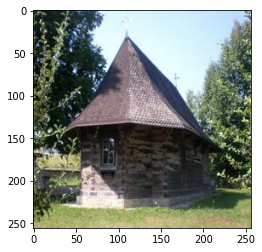

cottage


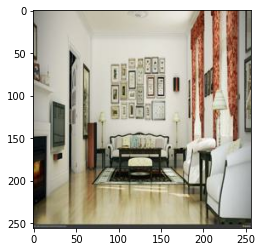

office


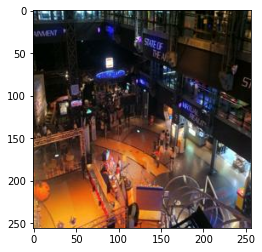

amusement_arcade


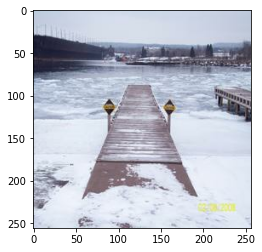

pier


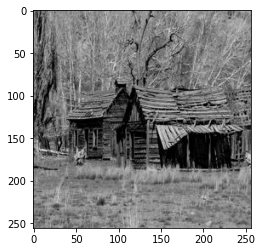

cabin/outdoor


In [ ]:
for x in train_dataset.take(5):
  plt.imshow(x['image'])
  plt.show()
  print(class_names[x['label']])

In [ ]:
IMAGE_SIZE=128

@tf.function
def preprocess(data):
  image=data['image']
  image=tf.cast(image,tf.float32)/127.5-1
  image=tf.image.resize(image,(IMAGE_SIZE, IMAGE_SIZE))
  return image,data['label']

train_dataset=train_dataset.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class ConditionBatchNormalization(tf.keras.Model):
  def __init__(self):
    super(ConditionBatchNormalization, self).__init__()
    self.decay = 0.9
    self.epsilon = 1e-05
    self.test_mean=tf.Variable(initial_value=0, trainable=False, dtype=tf.float32)
    self.test_var=tf.Variable(initial_value=1, trainable=False, dtype=tf.float32)

  def build(self, input_shape):
    self.num_channels=input_shape[0][-1]
    self.beta_mapping=tf.keras.layers.Dense(self.num_channels)
    self.gamma_mapping=tf.keras.layers.Dense(self.num_channels)
    
  def call(self, x, training=None):
    #Generate beta, gamma
    x, conditions = x
    beta = self.beta_mapping(conditions)
    gamma = self.gamma_mapping(conditions)

    beta = tf.reshape(beta, shape=[-1, 1, 1, self.num_channels])
    gamma = tf.reshape(gamma, shape=[-1, 1, 1, self.num_channels])
    if training:
        #Calculate mean and varience of X.
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2])
        #Calculate parameters for test set 
        self.test_mean = self.test_mean * self.decay + batch_mean * (1 - self.decay)
        self.test_var = self.test_var * self.decay + batch_var * (1 - self.decay)

        return tf.nn.batch_normalization(x, batch_mean, batch_var, beta, gamma, self.epsilon)
    else:
        return tf.nn.batch_normalization(x, self.test_mean, self.test_var, beta, gamma, self.epsilon)

class SelfAttention(tf.keras.Model):
  def __init__(self):
    super(SelfAttention, self).__init__()

  def build(self, input_shape):
    self.num_channels=input_shape[-1]
    self.hw = input_shape[1]*input_shape[2]
    self.conv_f=tf.keras.layers.Conv2D(self.num_channels // 8, 1)
    self.conv_g=tf.keras.layers.Conv2D(self.num_channels // 8, 1)
    self.conv_h=tf.keras.layers.Conv2D(self.num_channels//2, 1)
    self.conv_o=tf.keras.layers.Conv2D(self.num_channels, 1)

  def call(self, x):
    bs = x.shape[0]
    f = self.conv_f(x)  # [bs, h, w, c']
    g = self.conv_g(x)  # [bs, h, w, c']
    h = self.conv_h(x)  # [bs, h, w, c]

    f=tf.keras.layers.Reshape([self.hw, f.shape[-1]])(f)
    g=tf.keras.layers.Reshape([self.hw, g.shape[-1]])(g)
    h=tf.keras.layers.Reshape([self.hw, h.shape[-1]])(h)
    # N = h * w
    s = tf.matmul(g, f, transpose_b=True)  # # [bs, N, N]
    beta = tf.nn.softmax(s)  # attention map

    o = tf.matmul(beta, h)  # [bs, N, C]
    o = tf.keras.layers.Reshape([x.shape[1], x.shape[2], self.num_channels//2])(o)
    o = self.conv_o(o)
      # [bs, h, w, C]
    return x + o

BIGGAN Architecture Implementations - BigGAN 128

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       46720       class[0][0]                      
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 20)           0           noise[0][0]                      
____________________________________________________________________________________________

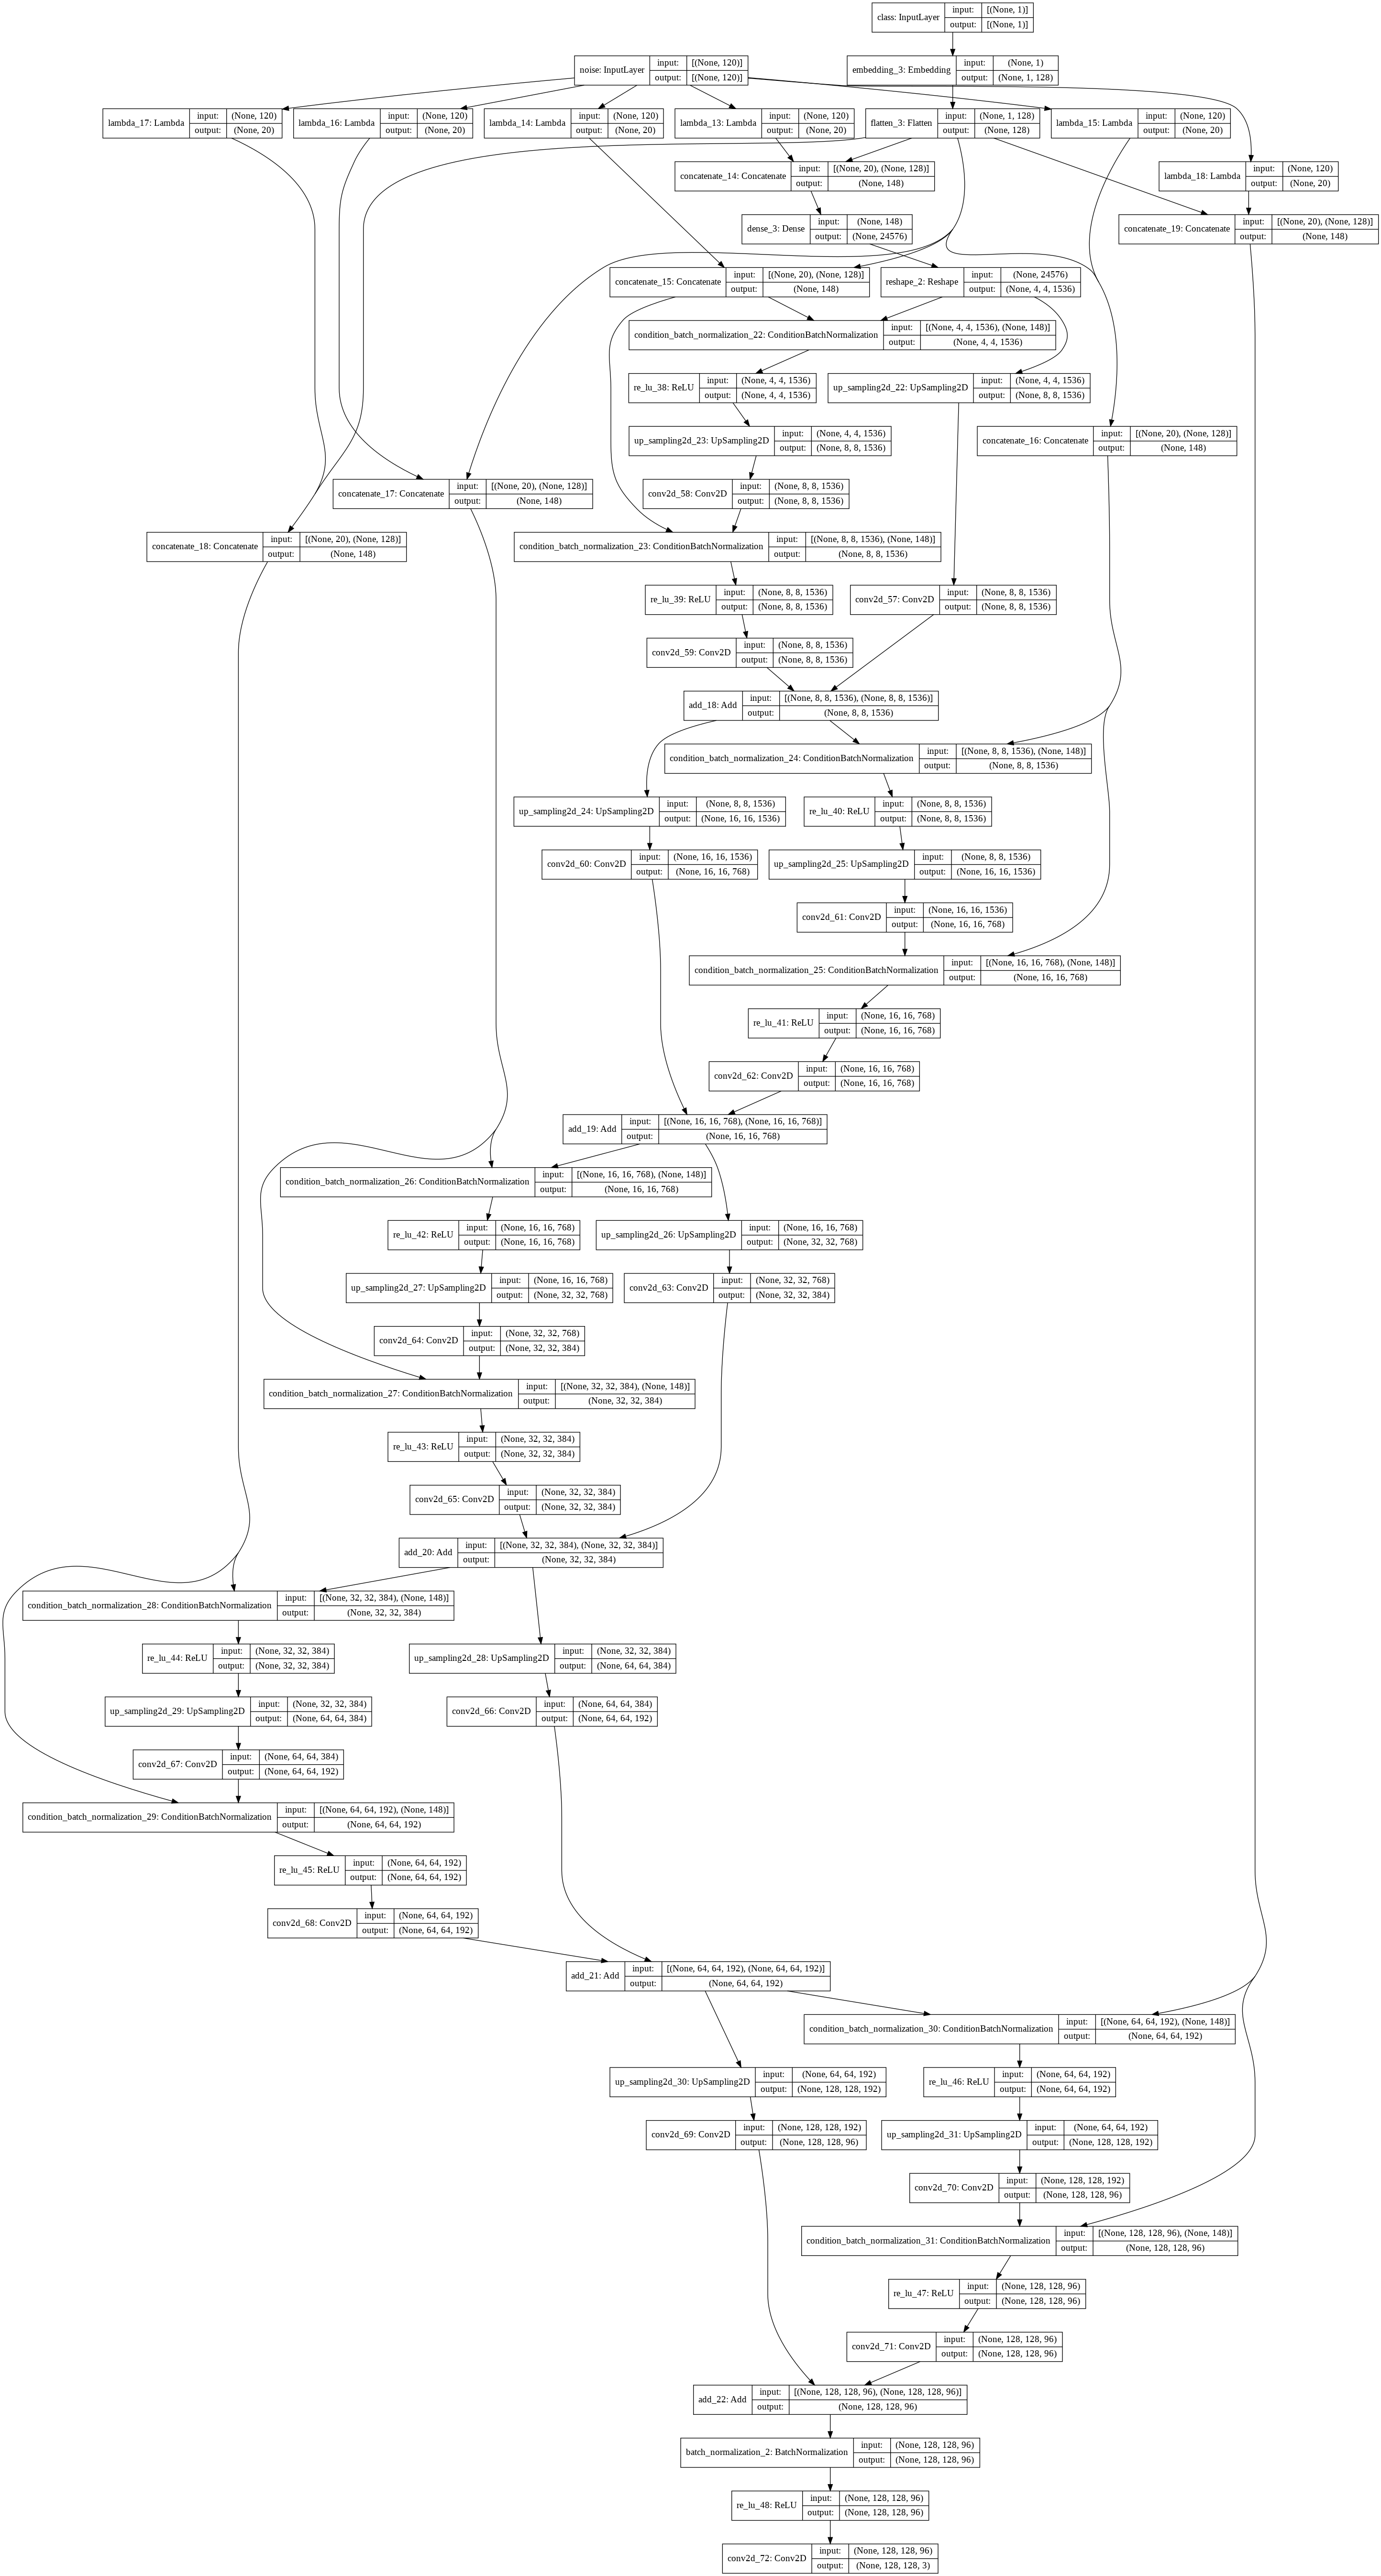

In [ ]:
#BigGAN 128 - G
latent_dim = 120
slice_latent_dim = 20
class_dims = 128
channels = 96

def residual_block_up(image_input, concat_input, channels):  

    block_a=tf.keras.layers.UpSampling2D()(image_input)
    block_a=tf.keras.layers.Conv2D(channels,1)(block_a)

    block_b=ConditionBatchNormalization()([image_input, concat_input])
    block_b=tf.keras.layers.ReLU()(block_b)
    block_b=tf.keras.layers.UpSampling2D()(block_b)
    
    block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)
    block_b=ConditionBatchNormalization()([block_b, concat_input])
    block_b=tf.keras.layers.ReLU()(block_b)
    block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)

    final_output=tf.keras.layers.Add()([block_a,block_b])
    return final_output

def crop_noise(noise, idx):
    return noise[:, idx*slice_latent_dim : (idx+1)*slice_latent_dim]

noise=keras.Input(shape=(latent_dim,),name='noise')

input_classes=tf.keras.layers.Input(shape=(1,),name='class')
input_classes_embedding=tf.keras.layers.Embedding(class_types,class_dims)(input_classes)
input_classes_embedding=tf.keras.layers.Flatten()(input_classes_embedding)

noise_slice=tf.keras.layers.Lambda(lambda x:crop_noise(x, idx=0))(noise)
model=tf.keras.layers.concatenate([noise_slice,input_classes_embedding])
model=tf.keras.layers.Dense(4* 4* 16 * channels)(model)
model=tf.keras.layers.Reshape((4,4,16 * channels))(model)

non_local_block=[False, False, False,True,False]
channel_multipliers=[16, 8, 4, 2, 1]
for x in range(5):
    noise_slice=tf.keras.layers.Lambda(lambda x:crop_noise(x, idx=0))(noise)
    concat=tf.keras.layers.concatenate([noise_slice,input_classes_embedding])

    model=residual_block_up(model, concat, channels*channel_multipliers[x])
    if non_local_block[x]:
      model=SelfAttention()(model)

model=tf.keras.layers.BatchNormalization()(model)
model=tf.keras.layers.ReLU()(model)
model=tf.keras.layers.Conv2D(3,3,padding='same',activation='tanh')(model)

generator=tf.keras.models.Model([noise,input_classes],model)
generator.summary()
tf.keras.utils.plot_model(generator,show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 96) 2688        image[0][0]                      
__________________________________________________________________________________________________
re_lu_49 (ReLU)                 (None, 128, 128, 96) 0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 128, 128, 192 166080      re_lu_49[0][0]                   
____________________________________________________________________________________________

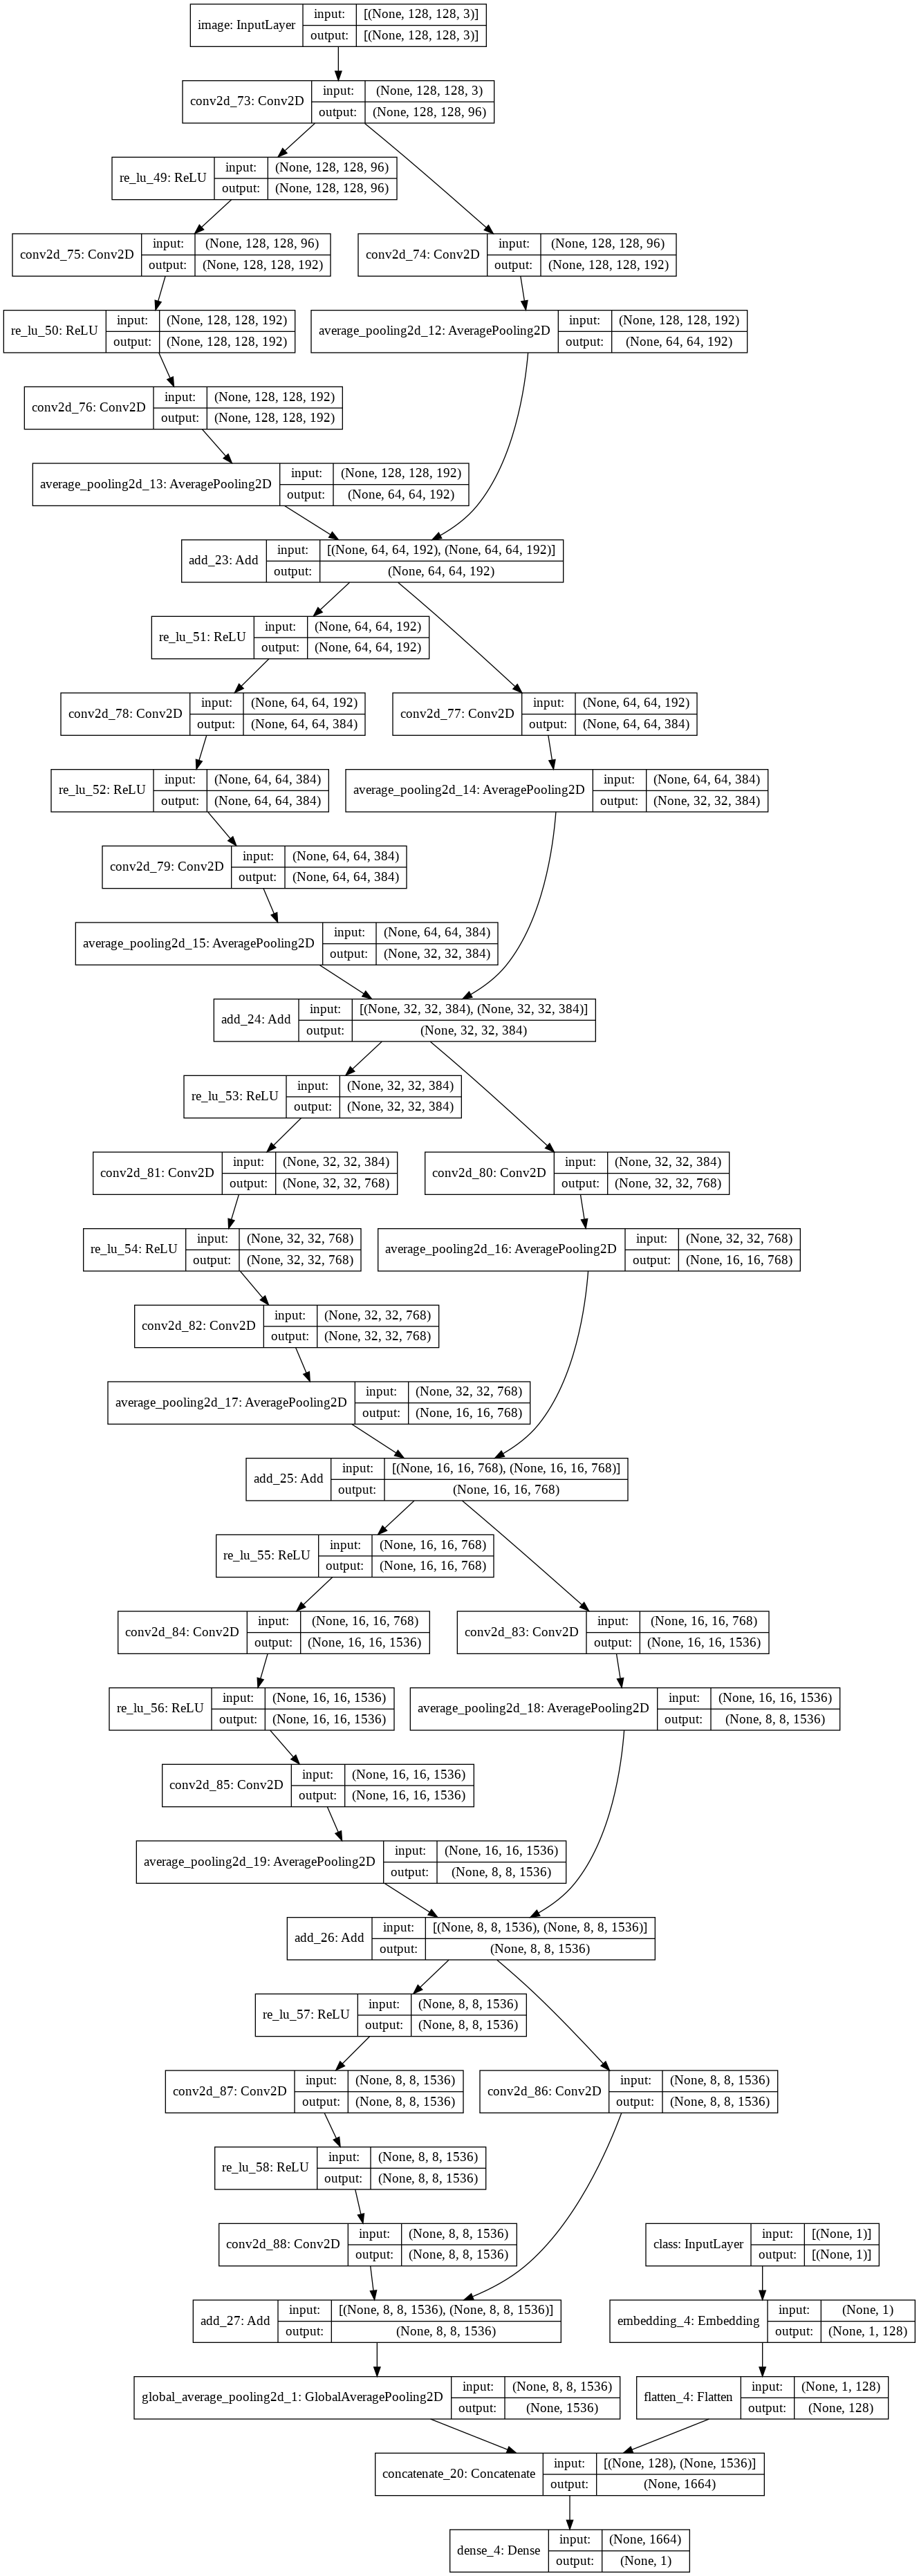

In [ ]:
#BigGAN 128 - D
def residual_block_down(input_image,channels,down=True):
  block_a=tf.keras.layers.Conv2D(channels,1)(input_image)
  if down:
    block_a=tf.keras.layers.AveragePooling2D()(block_a)

  block_b=tf.keras.layers.ReLU()(input_image)
  block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)
  block_b=tf.keras.layers.ReLU()(block_b)
  block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)
  if down:
    block_b=tf.keras.layers.AveragePooling2D()(block_b)

  final_output=tf.keras.layers.Add()([block_a,block_b])
  return final_output

input_image=tf.keras.layers.Input(shape=(128, 128, 3),name='image')

input_classes=tf.keras.layers.Input(shape=(1,),name='class')
input_classes_embedding=tf.keras.layers.Embedding(class_types,class_dims)(input_classes)
input_classes_embedding=tf.keras.layers.Flatten()(input_classes_embedding)

model=tf.keras.layers.Conv2D(channels,3,1,padding='same')(input_image)

non_local_block=[True,False,False,False,False]
down_list=[True,True,True,True,False]
channel_multipliers=[2,4,8,16,16]
for x in range(5):
  model=residual_block_down(model,channels=channels*channel_multipliers[x],down=down_list[x])
  if non_local_block[x]:
    model=SelfAttention()(model)
#Final residual block
model=tf.keras.layers.GlobalAveragePooling2D()(model)

model=tf.keras.layers.concatenate([input_classes_embedding,model])
model=tf.keras.layers.Dense(1)(model)

discriminator=tf.keras.models.Model([input_image, input_classes],model)
discriminator.summary()
tf.keras.utils.plot_model(discriminator,show_shapes=True)

BIGGAN Architecture Implementations - BigGAN 256

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
noise (InputLayer)              [(None, 140)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       46720       class[0][0]                      
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 20)           0           noise[0][0]                      
______________________________________________________________________________________________

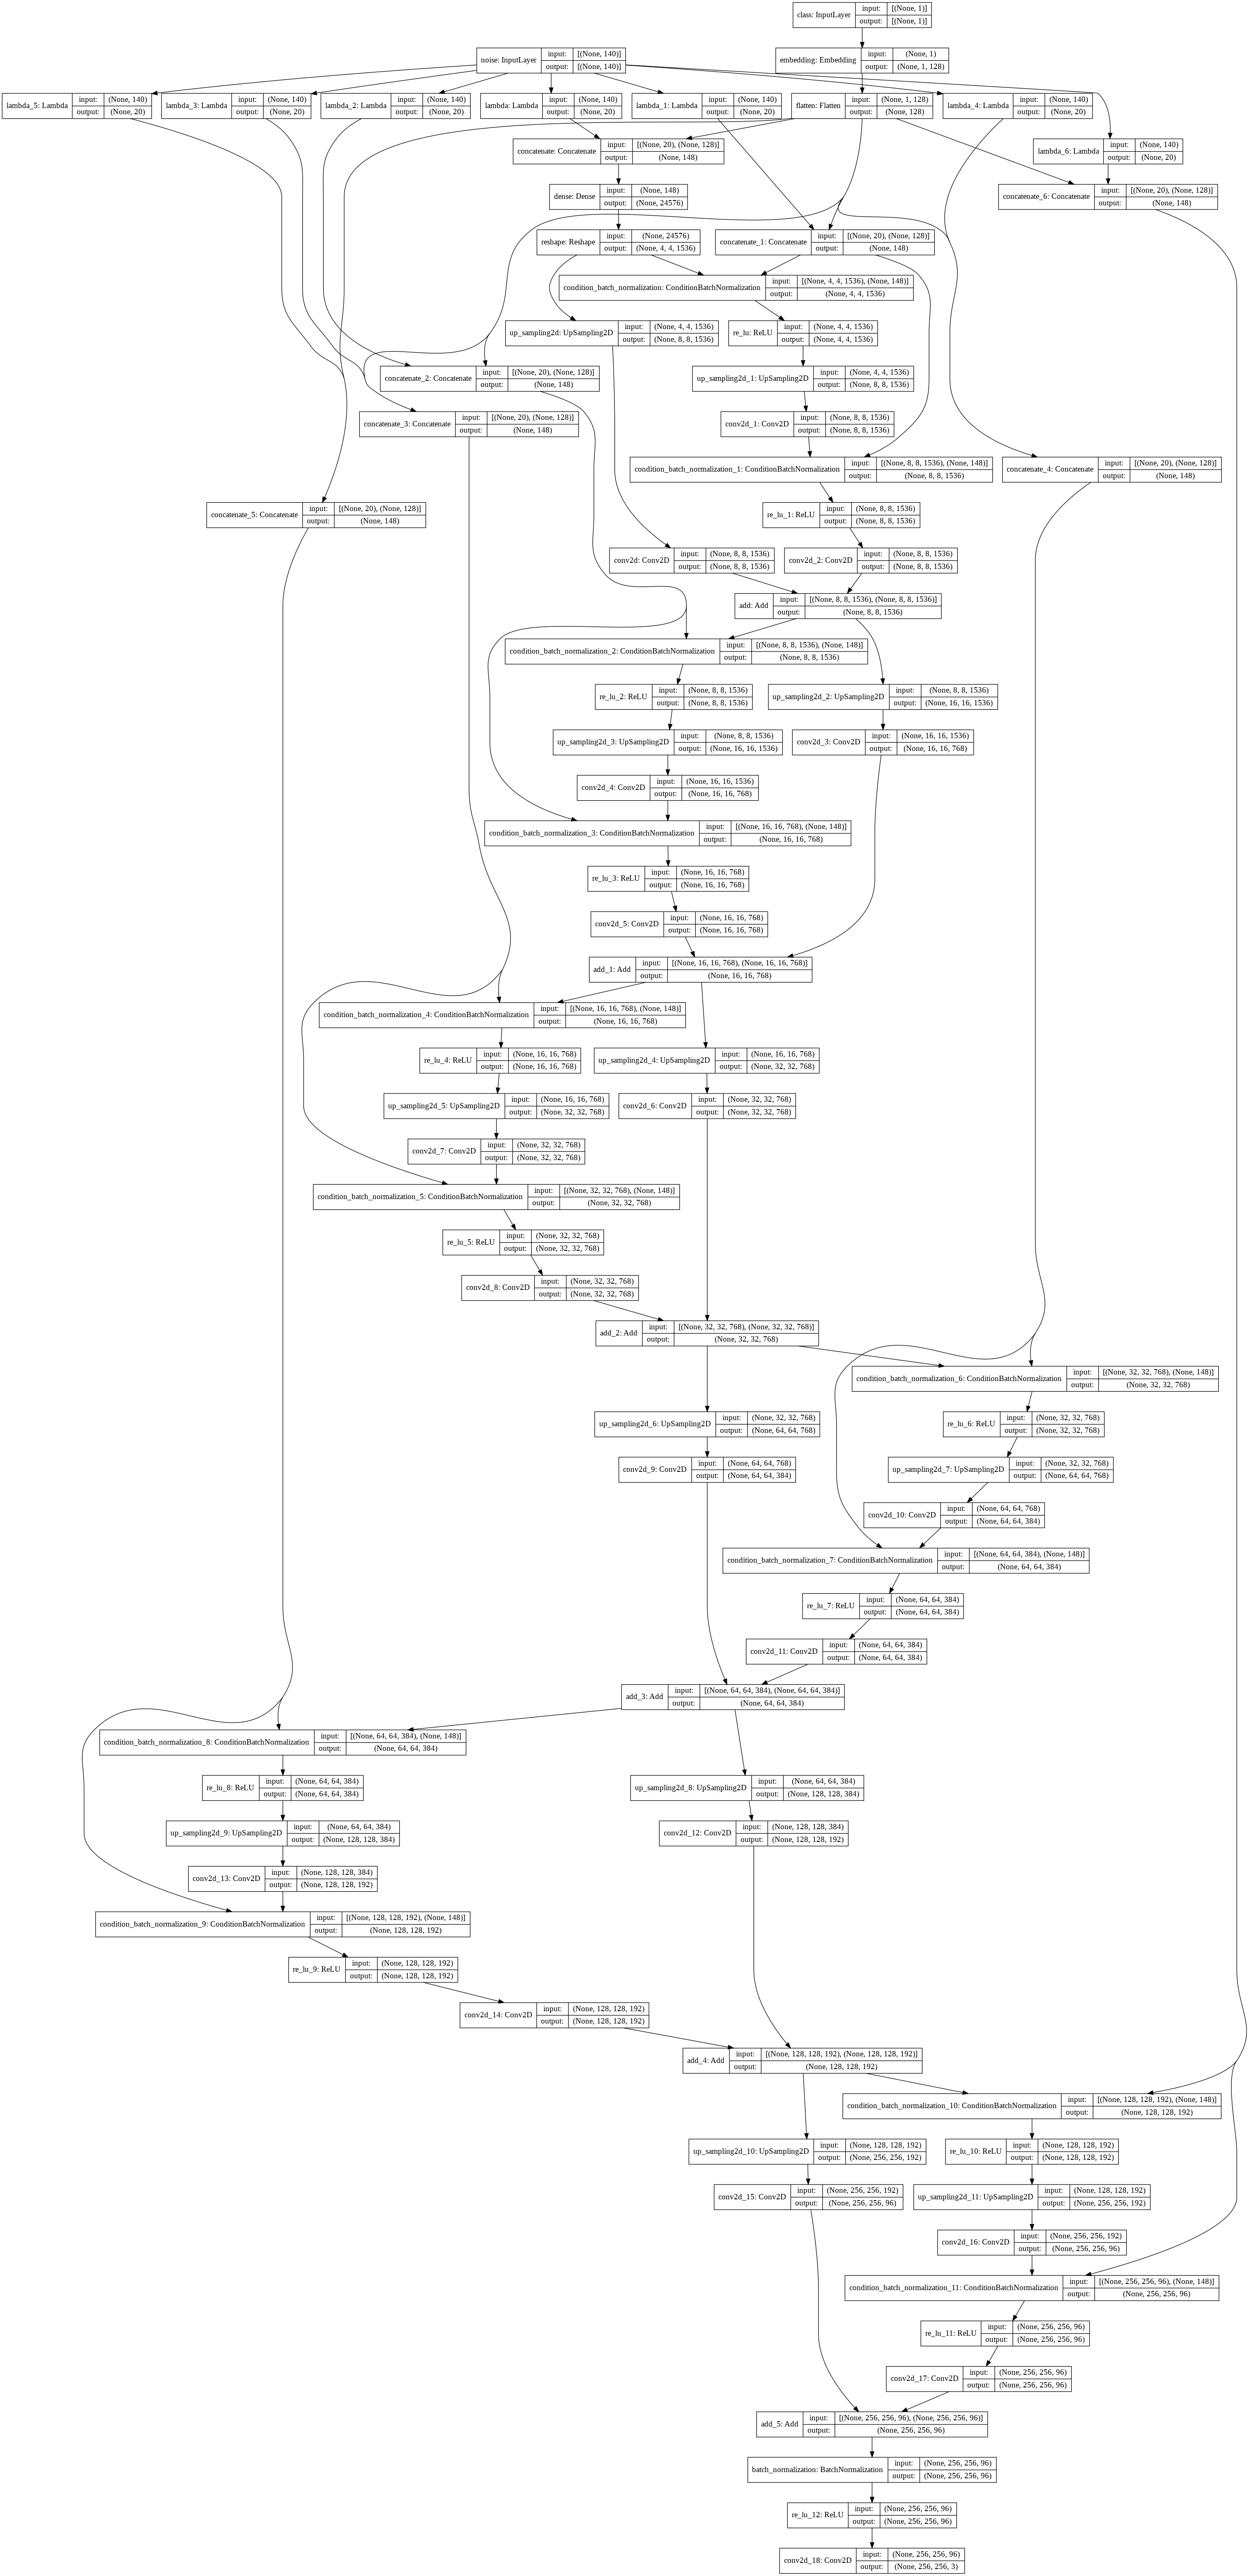

In [ ]:
#BigGAN 256 - G
latent_dim = 140
slice_latent_dim=20
class_dims = 128
channels = 96

def residual_block_up(image_input, concat_input, channels):  

    block_a=tf.keras.layers.UpSampling2D()(image_input)
    block_a=tf.keras.layers.Conv2D(channels,1)(block_a)

    block_b=ConditionBatchNormalization()([image_input, concat_input])
    block_b=tf.keras.layers.ReLU()(block_b)
    block_b=tf.keras.layers.UpSampling2D()(block_b)
    
    block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)
    block_b=ConditionBatchNormalization()([block_b, concat_input])
    block_b=tf.keras.layers.ReLU()(block_b)
    block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)

    final_output=tf.keras.layers.Add()([block_a,block_b])
    return final_output

def crop_noise(noise, idx):
    return noise[:, idx*slice_latent_dim : (idx+1)*slice_latent_dim]

noise=keras.Input(shape=(latent_dim,),name='noise')

input_classes=tf.keras.layers.Input(shape=(1,),name='class')
input_classes_embedding=tf.keras.layers.Embedding(class_types,class_dims)(input_classes)
input_classes_embedding=tf.keras.layers.Flatten()(input_classes_embedding)

noise_slice=tf.keras.layers.Lambda(lambda x:crop_noise(x, idx=0))(noise)
model=tf.keras.layers.concatenate([noise_slice,input_classes_embedding])
model=tf.keras.layers.Dense(4* 4* 16 * channels)(model)
model=tf.keras.layers.Reshape((4,4,16*channels))(model)

non_local_block=[False, True, False,False,False,False,False]
channel_multipliers=[16, 16, 8, 8, 4, 2, 1]
for x in range(1, 7):
    noise_slice=tf.keras.layers.Lambda(lambda x:crop_noise(x, idx=0))(noise)
    concat=tf.keras.layers.concatenate([noise_slice,input_classes_embedding])

    model=residual_block_up(model, concat, channels*channel_multipliers[x])
    if non_local_block[x]:
      model=SelfAttention()(model)

model=tf.keras.layers.BatchNormalization()(model)
model=tf.keras.layers.ReLU()(model)
model=tf.keras.layers.Conv2D(3,3,padding='same',activation='tanh')(model)

generator=tf.keras.models.Model([noise,input_classes],model)
generator.summary()
tf.keras.utils.plot_model(generator,show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 96) 2688        image[0][0]                      
__________________________________________________________________________________________________
re_lu_13 (ReLU)                 (None, 256, 256, 96) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 192 166080      re_lu_13[0][0]                   
____________________________________________________________________________________________

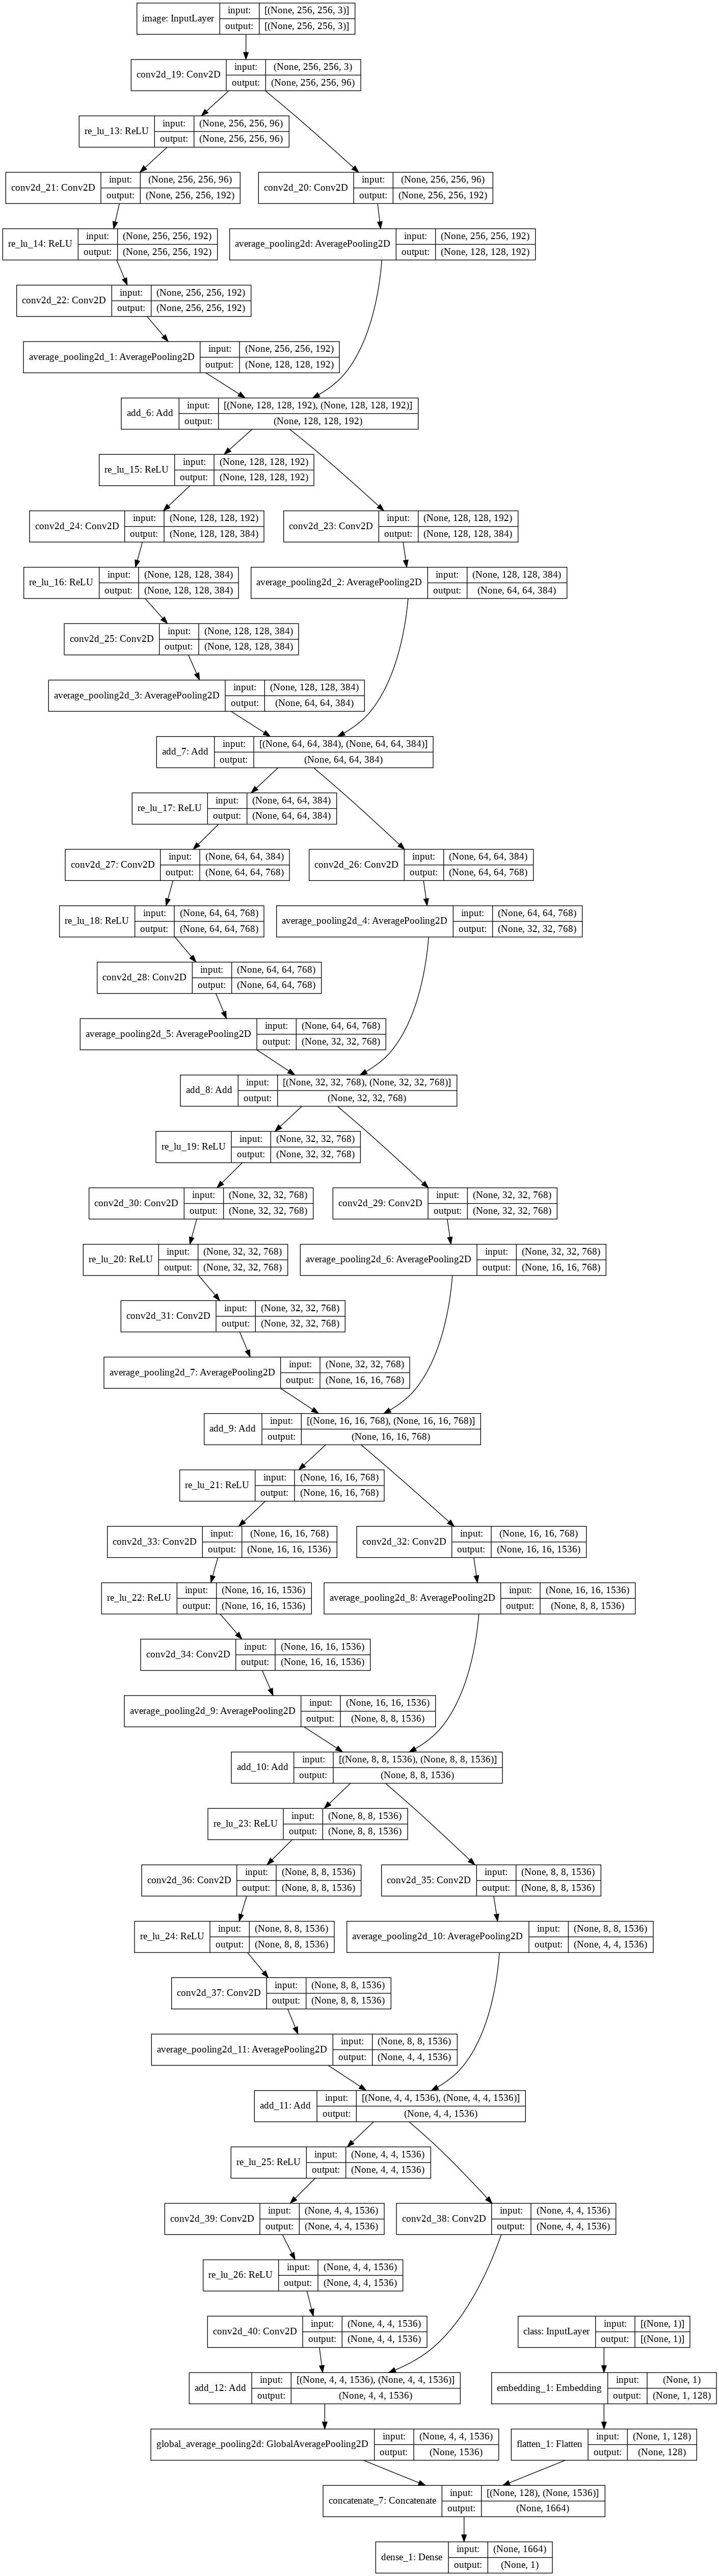

In [ ]:
#BigGAN 256 - D
def residual_block_down(input_image,channels,down=True):
  block_a=tf.keras.layers.Conv2D(channels,1)(input_image)
  if down:
    block_a=tf.keras.layers.AveragePooling2D()(block_a)

  block_b=tf.keras.layers.ReLU()(input_image)
  block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)
  block_b=tf.keras.layers.ReLU()(block_b)
  block_b=tf.keras.layers.Conv2D(channels,3,padding='same')(block_b)
  if down:
    block_b=tf.keras.layers.AveragePooling2D()(block_b)

  final_output=tf.keras.layers.Add()([block_a,block_b])
  return final_output

input_image=tf.keras.layers.Input(shape=(256, 256, 3),name='image')

input_classes=tf.keras.layers.Input(shape=(1,),name='class')
input_classes_embedding=tf.keras.layers.Embedding(class_types,class_dims)(input_classes)
input_classes_embedding=tf.keras.layers.Flatten()(input_classes_embedding)

model=tf.keras.layers.Conv2D(channels,3,1,padding='same')(input_image)

non_local_block=[False,False,False,True,False,False,False]
down_list=[True,True,True,True,True,True,False]
channel_multipliers=[2,4,8,8,16,16,16]
for x in range(7):
  model=residual_block_down(model,channels=channels*channel_multipliers[x],down=down_list[x])
  if non_local_block[x]:
    model=SelfAttention()(model)
#Final residual block
model=tf.keras.layers.GlobalAveragePooling2D()(model)

model=tf.keras.layers.concatenate([input_classes_embedding,model])
model=tf.keras.layers.Dense(1)(model)

discriminator=tf.keras.models.Model([input_image, input_classes],model)
discriminator.summary()
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, g_loss_fn, d_loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data_batch):
        real_images,anno=data_batch
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        fake_anno=tf.cast(tf.random.uniform(shape=[batch_size,1]) * class_types, tf.int32)

        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            generated_images = self.generator({'noise':random_latent_vectors, 'class':fake_anno})
            gen_predictions = self.discriminator({'image':generated_images,'class':fake_anno})
            real_predictions = self.discriminator({'image':real_images,'class':anno})
            d_loss = self.d_loss_fn(real_predictions, gen_predictions)
            g_loss = self.g_loss_fn(gen_predictions)

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(d_grads, self.discriminator.trainable_weights)
        )

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, noise=None, anno=None):
        self.num_img = num_img
        self.latent_dim = latent_dim
        if noise==None:
          self.random_latent_vectors = random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
        else:
          self.random_latent_vectors=noise
        
        if anno==None:
          self.fake_anno=fake_anno=tf.cast(np.tile(np.arange(10),10),tf.int32)
        else:
          self.fake_anno=anno
    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator({'noise':self.random_latent_vectors,'class':self.fake_anno})
        generated_images = generated_images*127.5+127.5
        generated_images.numpy()

        fig=plt.figure(figsize=(20,20))
        for i in range(self.num_img):
            plt.subplot(10,10,i + 1)
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')
        plt.savefig(f'generated_image_EPOCH_{epoch}.png')

In [ ]:
num_img=100
random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
fake_anno=tf.cast(np.tile(np.arange(10),10),tf.int32)

In [ ]:
def hinge_loss_d(true_pred, fake_pred):
  real_loss=tf.math.minimum(tf.zeros_like(true_pred), -1 + true_pred)
  fake_loss=tf.math.minimum(tf.zeros_like(fake_pred), -1 - fake_pred)
  return real_loss + fake_loss
def hinge_loss_g(fake_pred):
  return fake_pred

bce=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_ce(fake_output):
  return bce(tf.zeros_like(fake_output),fake_output)
def discriminator_ce(real_output, fake_output):
  real_loss = bce(tf.zeros_like(real_output), real_output)
  fake_loss = bce(tf.ones_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

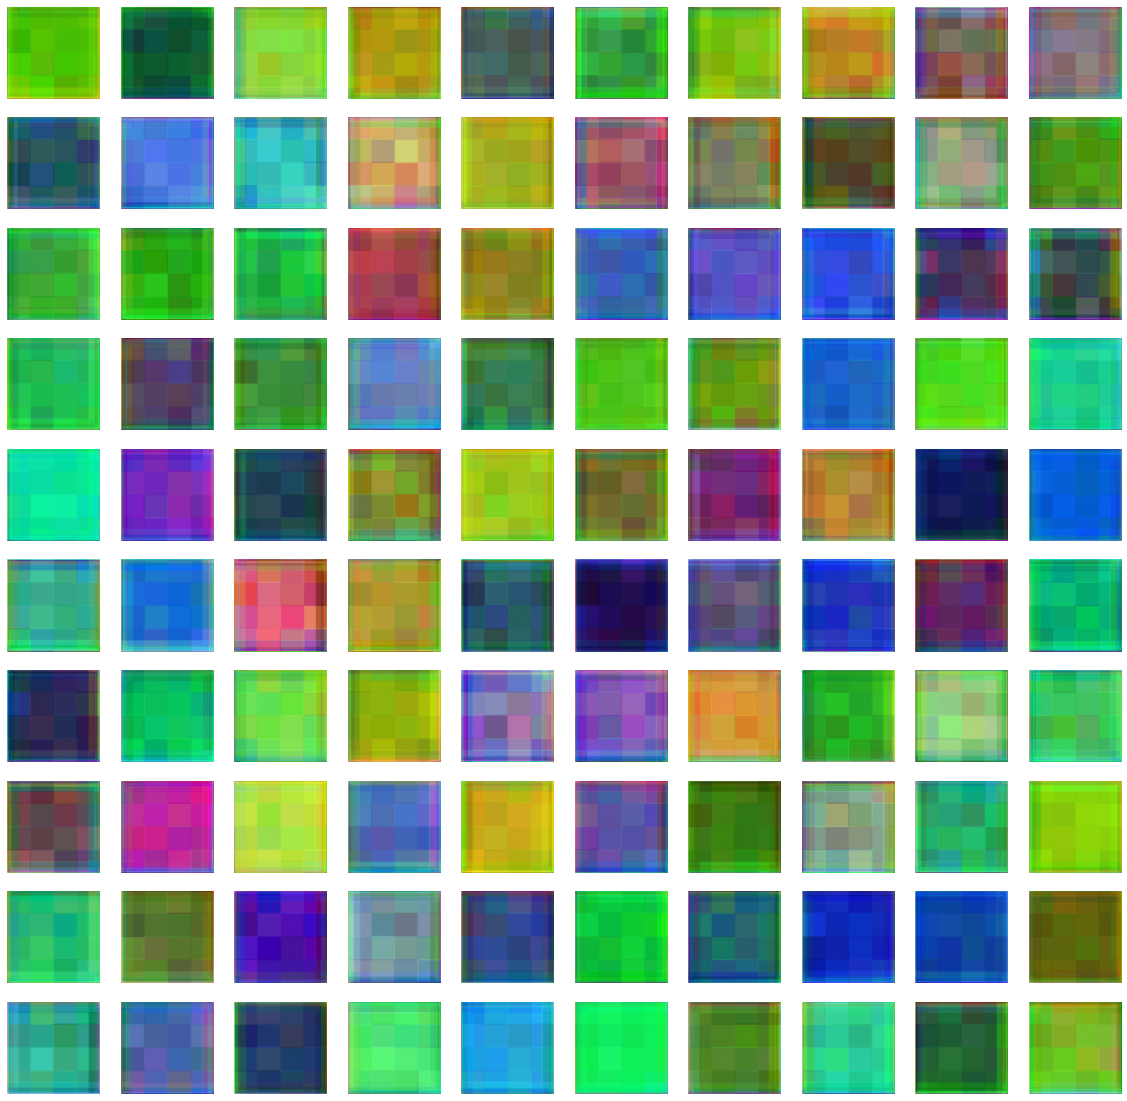

[[ 0.11760981]
 [ 0.01071254]
 [ 0.06210464]
 [ 0.15935922]
 [-0.00349116]
 [ 0.0208493 ]
 [ 0.09370491]
 [ 0.13692613]
 [ 0.02718419]
 [ 0.00865048]
 [-0.01907162]
 [ 0.05074065]
 [-0.02550903]
 [ 0.08350949]
 [ 0.146008  ]
 [ 0.04613276]
 [ 0.01332407]
 [ 0.04808674]
 [ 0.01509549]
 [ 0.04874645]
 [ 0.01679304]
 [ 0.06873631]
 [-0.01861221]
 [ 0.07498245]
 [ 0.09615468]
 [-0.00341488]
 [ 0.02420569]
 [ 0.02226333]
 [ 0.00316689]
 [-0.00844729]
 [-0.03060537]
 [ 0.01989812]
 [ 0.00397291]
 [ 0.02278461]
 [-0.00623431]
 [ 0.0764828 ]
 [ 0.0491771 ]
 [-0.00666994]
 [ 0.07837657]
 [-0.04275908]
 [-0.02432556]
 [ 0.05459591]
 [-0.02845594]
 [ 0.0619877 ]
 [ 0.16640554]
 [ 0.08426957]
 [ 0.02487763]
 [ 0.12361299]
 [-0.02209274]
 [-0.03281417]
 [-0.02705502]
 [ 0.01222721]
 [ 0.07205229]
 [ 0.13322903]
 [-0.01897135]
 [-0.00419703]
 [-0.02174868]
 [-0.02142298]
 [ 0.02546363]
 [-0.08299755]
 [-0.00430005]
 [-0.03839479]
 [ 0.03677891]
 [ 0.15915345]
 [ 0.01917227]
 [ 0.03571892]
 [ 0.13766

In [ ]:
gen_images=generator({'noise':random_latent_vectors,'class':fake_anno})
fig=plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i + 1)
    img = keras.preprocessing.image.array_to_img(gen_images[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()
print(discriminator({'image':gen_images,'class':fake_anno}).numpy())

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    d_loss_fn=hinge_loss_d,
    g_loss_fn=hinge_loss_g,
)

gan.fit(train_dataset.batch(128), epochs=epochs, callbacks=[GANMonitor(num_img=num_img, latent_dim=latent_dim, noise=random_latent_vectors, anno=fake_anno)])

Epoch 1/100


ResourceExhaustedError: ignored